## Explaining a classfier 

It's good to able to explain what an algorithm is doing (esp in public sector).

It boosts confidence in the ML, good for transparency, and is useful in iterating the model. 

This uses the python package lime (Local Interpretable Model-Agnostic Explanations), an implementation by the authors of their paper - 
https://arxiv.org/abs/1602.04938

In [1]:
! pip install lime 

In [2]:
import sklearn
import sklearn.ensemble
import numpy as np
import lime
import lime.lime_tabular
from __future__ import print_function
np.random.seed(2)

In [3]:
blob_account_name = "parlpublic"
blob_account_key = "xKEIV42ZsO8eL2IPjvbLarR2Xu1brxGucDauvVytPXD1uKhAfYUId7SwbGF82FslfkKebPB/ic6/RcPYnNBO6w==" 
container = "trainingdata" 
blobname = "5000_edms_justonetopic.csv"
datafile = "output.txt" 
import os
import pandas as pd
from azure.storage.blob import BlockBlobService

dirname = os.getcwd()

blob_service = BlockBlobService(account_name=blob_account_name,account_key=blob_account_key)
blob_service.get_blob_to_path(container, blobname, datafile)

edm = pd.read_csv(datafile, header = 0)
os.remove(os.path.join(dirname, datafile))
print(edm.shape)
edm.head()

(5000, 2)


doc                 topic
0  That this House notes the conviction in the Un...        House of Lords
1  That this House congratulates the US corporate...         North America
2  That this House is dismayed by the report in t...               Speaker
3  That this House notes that, according to a No....  Members of the Lords
4  That this House notes the appointment of a new...        House of Lords

In [4]:
# load in tag hierarchy to extract top terms
import json
with open("tag_hierarchy.json", 'r') as f:
    data = json.load(f) 

In [5]:
# Cleaning
import re

def clean_text(string):
    string = re.sub(r"\d", "", string) # remove numbers  
    string = re.sub(r"_+", "", string) # remove consecutive underscores
    string = re.sub(r"<[^>]*>", " ", string) #remove all html tags
    string = re.sub(r"[^0-9a-zA-Z]+", " ", string)  # remove speacial chars
    string = string.lower() # tranform to lower case    
    
    return string.strip()

edm["doc"] = edm.doc.apply(clean_text)

def get_parent(term):
    for i in data['children']:
        for k in i['children']:
            if term == k['name']:
                return i['name']
            if "children" in k:
                for j in k['children']:
                    if term == j['name']:
                        return get_parent(k['name'])
            
# get_parent("Supported housing")

edm["topic"] = edm.topic.apply(get_parent)

edm.head()

doc  \
0  that this house notes the conviction in the un...   
1  that this house congratulates the us corporate...   
2  that this house is dismayed by the report in t...   
3  that this house notes that according to a no d...   
4  that this house notes the appointment of a new...   

                                 topic  
0  Parliament, government and politics  
1                International affairs  
2  Parliament, government and politics  
3  Parliament, government and politics  
4  Parliament, government and politics

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,max_features=1000,stop_words='english')
tf_vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.95, max_features=1000, min_df=2,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [7]:
X = tf_vectorizer.fit_transform(edm['doc'])
X

<5000x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 150811 stored elements in Compressed Sparse Row format>

In [8]:
doc_array = X.toarray()  
doc_array.astype(float)

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [9]:
analyze = tf_vectorizer.build_analyzer()
analyze("we shall fight on the beaches")

['shall', 'fight', 'beaches']

In [10]:
feature_names = tf_vectorizer.get_feature_names()

In [11]:
train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(doc_array, edm.topic, train_size=0.80)
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
rf.fit(train, labels_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [12]:
sklearn.metrics.accuracy_score(labels_test, rf.predict(test))

0.57399999999999995

In [13]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(edm.topic)
classes_names = le.classes_

In [14]:
explainer = lime.lime_tabular.LimeTabularExplainer(train, feature_names=feature_names, class_names=classes_names, discretize_continuous=True)

C:\Users\leungr\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [15]:
i = np.random.randint(0, len(test))
tf_vectorizer.inverse_transform(test[i])

[array(['calls', 'chief', 'concern', 'court', 'engage', 'ensure',
        'following', 'home', 'legislation', 'notes', 'officers', 'order',
        'police', 'properly', 'public', 'recent', 'secretary', 'senior',
        'settlement'], 
       dtype='<U15')]

In [16]:
exp = explainer.explain_instance(test[i], rf.predict_proba, num_features=10, top_labels=3)
exp.show_in_notebook(show_table=True, show_all=False)

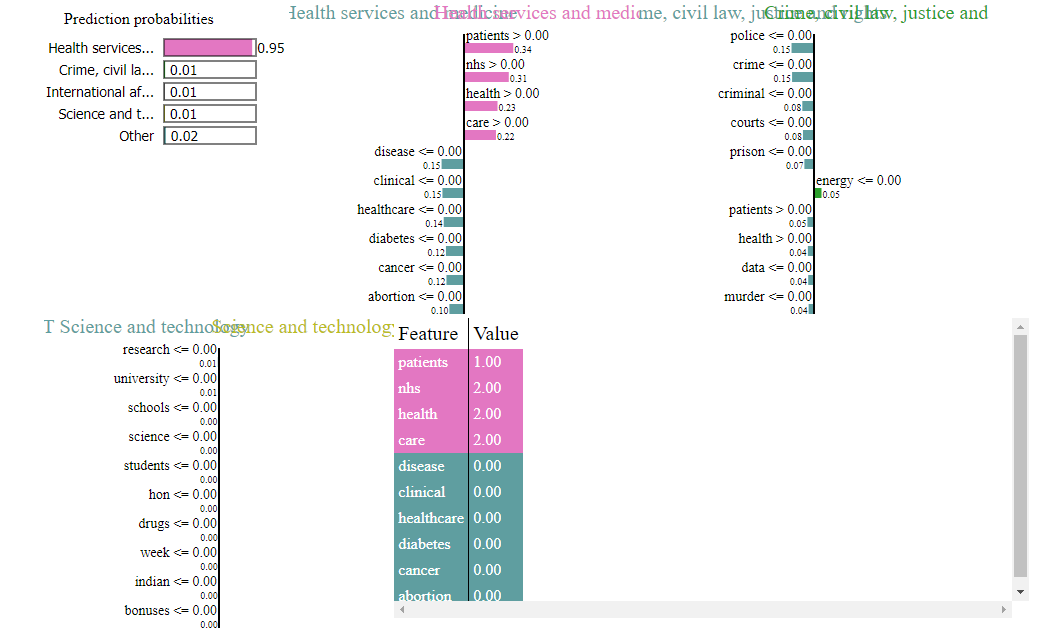

In [18]:
# Example that a piece of text that's classified as health services with .95 probability 
# You can tell for each class (here there are 3), which text features contributed to the prediction and to what degree
from IPython.display import Image
Image(filename='explainml.png') 

## Notes

This isn't the model that'd be used in production, just one sklearn random forests implementation. Though its possible to plug this python script into Azure ML studio (compatible with R and python) and inspect particular ones as requested. With human-in-the-loop retraining setups, may want to save historic models if you want audit trail.

Besides transprency can check the predictions with low confidence to seek improvements. 

Also this relies on human readable text features. If use feature hashing, have to reverse hash if you want text labels

To further investigate:
- how this works with more classes, instead of just top 20
- deep learning classifiers
- integrating with Azure to store output into blob
- what are good measures to track across retrained models?
- ...